In [50]:
import requests
import torch 
torch.hub.set_dir('/share/ju/tmp_dir_location/')
from PIL import Image
import cv2
import matplotlib.pyplot as plt 
import numpy as np
from segment_anything import sam_model_registry, SamPredictor, SamAutomaticMaskGenerator
from lavis.models import load_model_and_preprocess
import pandas as pd

In [18]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))

In [19]:
def boundary(inputs):
    
    col = inputs.shape[1]
    inputs = inputs.reshape(-1)
    lens = len(inputs)
    start = np.argmax(inputs)
    end = lens - 1 - np.argmax(np.flip(inputs))
    top = start // col
    bottom = end // col
    
    return top, bottom

def seg_to_box(seg_mask, size):
    
    top, bottom = boundary(seg_mask)
    left, right = boundary(seg_mask.T)
    left, top, right, bottom = left / size, top / size, right / size, bottom / size # we normalize the size of boundary to 0 ~ 1

    return [left, top, right, bottom]

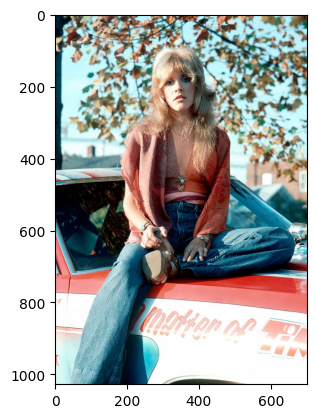

In [20]:
image = cv2.imread('/share/ju/lavis/test_images/stevie_nicks_outfit.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# # from local device
# img_path = './demo.jpg'
# image = Image.open(img_path).convert('RGB')

height, width, channel = image.shape
plt.imshow(image)

In [21]:
# parameters
device = "cuda" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if 'cuda' in device else torch.float32
model_type = 'vit_h'
checkpoint = '/share/ju/segmentation/caption-anything/segmenter/sam_vit_h_4b8939.pth'

# SAM initialization
model = sam_model_registry[model_type](checkpoint = checkpoint)
model.to(device)
predictor = SamPredictor(model)
mask_generator = SamAutomaticMaskGenerator(model)
predictor.set_image(np.array(image)) # load the image to predictor

print(device)
#model

cuda


105


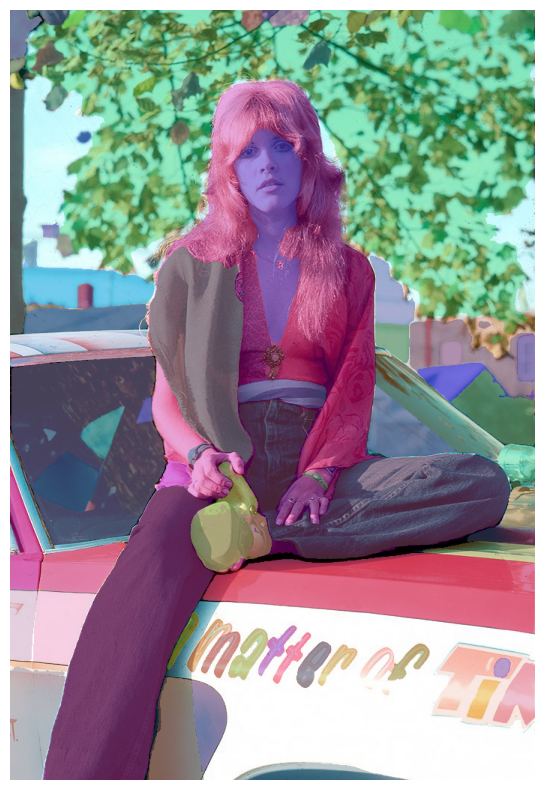

In [22]:
input_point = [[900, 950]] # A Nx2 array of point prompts to the model. Each point is in (X,Y) in pixels.
input_label = [1]           # A length N array of labels for the point prompts. 1 indicates a foreground point and 0 indicates a background point.
input_point = np.array(input_point)
input_label = np.array(input_label)
#masks, scores, logits = predictor.predict(point_coords = input_point, point_labels = input_label)
masks = mask_generator.generate(image)
#masks = masks[0, ...]
print(len(masks))
plt.figure(figsize=(10,10))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

In [69]:
def generate_mask_captions(image, masks, cls_lists): 
    #Tensor.cpu(image)
    # model, vis_processors, txt_processors = load_model_and_preprocess("clip_feature_extractor", model_type="ViT-B-32", is_eval=True, device=device)
    model, vis_processors, txt_processors = load_model_and_preprocess("clip_feature_extractor", model_type="ViT-B-16", is_eval=True, device=device)
    
    garment_data = []
    
    for n in range(len(masks)): 
        
        img_data = []
        crop_mode = "wo_bg" # Optional['wo_bg', 'w_bg'], where w_bg and wo_bg refer to remain and discard background separately.

        if crop_mode == "wo_bg":
            masked_image = image * masks[n]['segmentation'][:,:,np.newaxis] + (1 - masks[n]['segmentation'][:,:,np.newaxis]) * 255
            masked_image = np.uint8(masked_image)
        else:
            masked_image = np.array(image)
        masked_image = Image.fromarray(masked_image)

        #display(masked_image.resize((width // 3, height // 3)))
        size = max(masks[n]['segmentation'].shape[0], masks[n]['segmentation'].shape[1])
        left, top, right, bottom = seg_to_box(masks[n]['segmentation'], size) # calculating the position of the top-left and bottom-right corners in the image
        #print(left, top, right, bottom)

        image_crop = masked_image.crop((left * size, top * size, right * size, bottom * size)) # crop the image
        #display(image_crop)
        
        
        #for prompt in text_prompts:
            #inputs = processor(image_crop, text = prompt, return_tensors = "pt").to(device, torch_dtype)
            #out = captioning_model.generate(**inputs, max_new_tokens = 200)
            #captions = processor.decode(out[0], skip_special_tokens = True).strip()
        
            #img_data.append(captions)
        
        #details.append(img_data)
        
        
        segment_data = [] 
        for key, cls_list in cls_lists.items(): 
            
            cls_names = [txt_processors["eval"](cls_nm) for cls_nm in cls_list]
            image_piece = vis_processors["eval"](image_crop).unsqueeze(0).to(device)
            
            sample = {"image": image_piece, "text_input": cls_names}

            clip_features = model.extract_features(sample)

            image_features = clip_features.image_embeds_proj
            text_features = clip_features.text_embeds_proj
            
            sims = (image_features @ text_features.t())[0] / 0.01
            probs = torch.nn.Softmax(dim=0)(sims).tolist()

            #for cls_nm, prob in zip(cls_names, probs):
                #print(f"{cls_nm}: \t {prob:.3%}")
            
            segment_data.append(probs[0])
        
        image_crop.save(f'./dissected_garment/{n:03}.jpg')
        
    return garment_data
        

In [70]:
cls_lists = {'fabric?': ['fabric', 'other']
    #['20s','30s','40s','50s','60s','70s','80s','90s','2000s','2010s']
            }

In [71]:
garment_data = generate_mask_captions(image, masks, cls_lists)

Empty DataFrame
Columns: [fabric?]
Index: []


/tmp/ipykernel_3444427/4200261898.py:55: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  garment_data[key].append(probs)


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 garment_data = generate_mask_captions(image, masks, cls_lists)                               │
│   2                                                                                              │
│                                                                                                  │
│ in generate_mask_captions:55                                                                     │
│                                                                                                  │
│   52 │   │   │   #for cls_nm, prob in zip(cls_names, probs):                                     │
│   53 │   │   │   │   #print(f"{cls_nm}: \t {prob:.3%}")                                          │
│   54 │   │   │   print(garment_data)                                                             │
│ ❱ 55 │   │   │   garment_data[key].append(probs)                                                 │
│   56 │   │                                                                                       │
│   57 │   │   image_crop.save(f'./dissected_garment/{n:03}.jpg')                                  │
│   58                                                                                             │
│                                                                                                  │
│ /share/ju/conda_virtualenvs/lavis/lib/python3.8/site-packages/pandas/core/series.py:3140 in      │
│ append                                                                                           │
│                                                                                                  │
│   3137 │   │   │   stacklevel=find_stack_level(),                                                │
│   3138 │   │   )                                                                                 │
│   3139 │   │                                                                                     │
│ ❱ 3140 │   │   return self._append(to_append, ignore_index, verify_integrity)                    │
│   3141 │                                                                                         │
│   3142 │   def _append(                                                                          │
│   3143 │   │   self, to_append, ignore_index: bool = False, verify_integrity: bool = False       │
│                                                                                                  │
│ /share/ju/conda_virtualenvs/lavis/lib/python3.8/site-packages/pandas/core/series.py:3155 in      │
│ _append                                                                                          │
│                                                                                                  │
│   3152 │   │   if any(isinstance(x, (ABCDataFrame,)) for x in to_concat[1:]):                    │
│   3153 │   │   │   msg = "to_append should be a Series or list/tuple of Series, got DataFrame"   │
│   3154 │   │   │   raise TypeError(msg)                                                          │
│ ❱ 3155 │   │   return concat(                                                                    │
│   3156 │   │   │   to_concat, ignore_index=ignore_index, verify_integrity=verify_integrity       │
│   3157 │   │   )                                                                                 │
│   3158                                                                                           │
│                                                                                                  │
│ /share/ju/conda_virtualenvs/lavis/lib/python3.8/site-packages/pandas/util/_decorators.py:331 in  │
│ wrapper                                                    

In [62]:
garment_data

,fabric?
0,0.210162
1,0.789838
